CHẠY MODEL TRÊN DỮ LIỆU ĐÃ XỬ LÝ (PROCESSED DATA)

--- KẾT QUẢ (RAW DATA) ---
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       970
           1       0.33      0.10      0.15        50

    accuracy                           0.95      1020
   macro avg       0.64      0.54      0.56      1020
weighted avg       0.92      0.95      0.93      1020


Ma trận nhầm lẫn:
[[960  10]
 [ 45   5]]


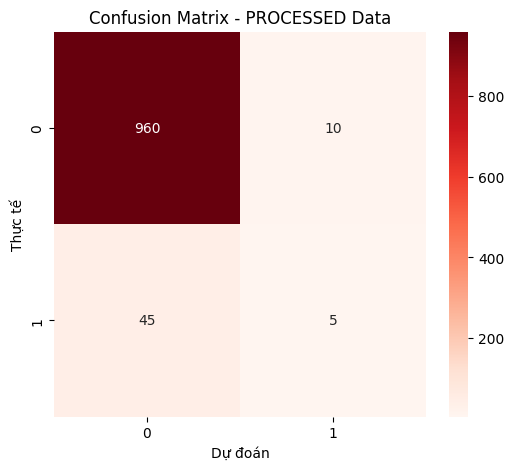

In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, fbeta_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from xgboost import XGBClassifier
import joblib


current_dir = Path.cwd()
data_dir = current_dir.parent.parent / "data"

print("="*60)
print("CHẠY MODEL TRÊN DỮ LIỆU ĐÃ XỬ LÝ (PROCESSED DATA)")
print("="*60)

# Thiết lập đường dẫn (sửa lại nếu cần thiết theo máy của bạn)
# Giả sử bạn đang chạy code ở thư mục gốc chứa thư mục data
processed_dir = data_dir / "processed"

# 1. Load dữ liệu đã chuẩn bị sẵn
# Train trên tập đã cân bằng (Balanced)
train_df = pd.read_csv(processed_dir / 'train_balanced.csv')
# Test trên tập test riêng biệt (đã scaled nhưng giữ nguyên tỷ lệ thực tế)
test_df = pd.read_csv(processed_dir / 'test.csv')

# 2. Tách Features và Target
X_train = train_df.drop(columns=['stroke'])
y_train = train_df['stroke']

X_test = test_df.drop(columns=['stroke'])
y_test = test_df['stroke']

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# 3. Train Model
model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.03,
    scale_pos_weight=pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
    n_jobs=-1
)

# Bắt đầu đo thời gian
start = time.time()

model.fit(X_train, y_train)

# 5. Đánh giá
y_pred = model.predict(X_test)

end = time.time()
elapsed_time = end - start

print("\n--- KẾT QUẢ (RAW DATA) ---")
print(classification_report(y_test, y_pred))

# Tính accuracy
acc = accuracy_score(y_test, y_pred)

print("\nMa trận nhầm lẫn:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Vẽ Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix - PROCESSED Data')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()


THỬ NHIỀU THRESHOLD (TỐI ƯU F2 CHO CLASS 1):

==> Threshold (F2 tốt nhất): 0.114 | F2_1 = 0.410

--- KẾT QUẢ (RAW DATA) ---
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       970
           1       0.17      0.64      0.27        50

    accuracy                           0.83      1020
   macro avg       0.57      0.74      0.58      1020
weighted avg       0.94      0.83      0.87      1020

Accuracy (threshold tối ưu theo F2): 0.8275
Ma trận nhầm lẫn (threshold tối ưu theo F2):
[[812 158]
 [ 18  32]]


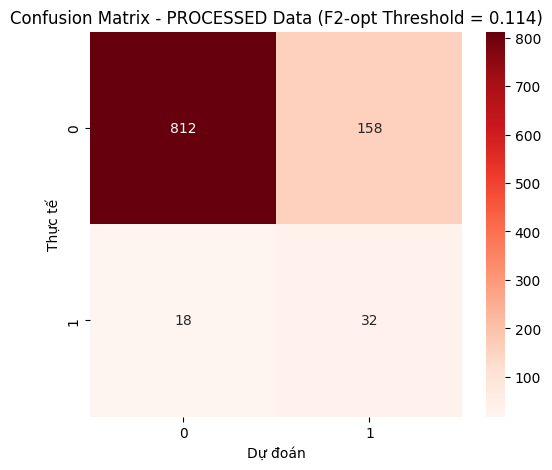

In [ ]:
y_proba = model.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.01, 0.50, 100)

best_thr_f2 = 0.5
best_f2 = -1
best_cm_f2 = None

print("="*60)
print("THỬ NHIỀU THRESHOLD (TỐI ƯU F2 CHO CLASS 1):")
print("="*60)

for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    f2 = fbeta_score(y_test, y_pred_thr, beta=2, pos_label=1)
    cm_thr = confusion_matrix(y_test, y_pred_thr)

    # print(f"Threshold = {thr:.3f} | F2_1 = {f2:.3f}")

    if f2 > best_f2:
        best_f2 = f2
        best_thr_f2 = thr
        best_cm_f2 = cm_thr

# print("-" * 70)
print(f"\n==> Threshold (F2 tốt nhất): {best_thr_f2:.3f} | F2_1 = {best_f2:.3f}")

y_pred_best_f2 = (y_proba >= best_thr_f2).astype(int)

print("\n--- KẾT QUẢ VỚI THRESHOLD TỐI ƯU THEO F2 ---")
print(classification_report(y_test, y_pred_best_f2))

acc_best_f2 = accuracy_score(y_test, y_pred_best_f2)
print(f"Accuracy (threshold tối ưu theo F2): {acc_best_f2:.4f}")
print("Ma trận nhầm lẫn (threshold tối ưu theo F2):")
print(best_cm_f2)


plt.figure(figsize=(6, 5))
sns.heatmap(best_cm_f2, annot=True, fmt="d", cmap="Reds")
plt.title(f"Confusion Matrix - PROCESSED Data (F2-opt Threshold = {best_thr_f2:.3f})")
plt.ylabel("Thực tế")
plt.xlabel("Dự đoán")
plt.show()


THỬ NHIỀU THRESHOLD (ƯU TIÊN RECALL_1, PREC_1 ≥ 0.10):

==> Threshold được chọn: 0.030
Precision_1 tốt nhất: 0.105
Recall_1 tốt nhất   : 0.860

--- KẾT QUẢ VỚI THRESHOLD TỐI ƯU THEO PREC ---
              precision    recall  f1-score   support

           0       0.99      0.62      0.76       970
           1       0.11      0.86      0.19        50

    accuracy                           0.63      1020
   macro avg       0.55      0.74      0.48      1020
weighted avg       0.95      0.63      0.74      1020

Accuracy (threshold tối ưu): 0.6343
Ma trận nhầm lẫn (threshold tối ưu):
[[604 366]
 [  7  43]]


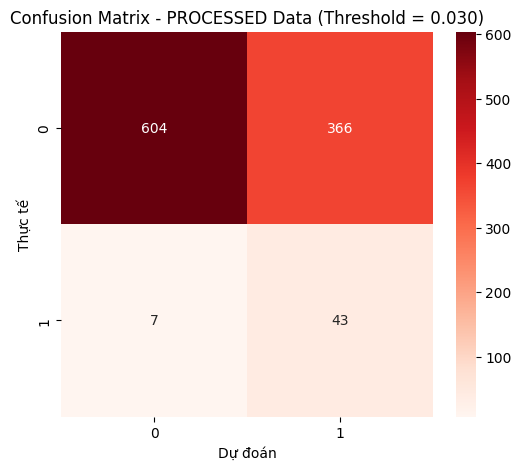

In [44]:
y_proba = model.predict_proba(X_test)[:, 1]

# Thử threshold mịn hơn một chút
thresholds = np.linspace(0.01, 0.50, 100)

best_thr = 0.5
best_recall_1 = 0.0
best_prec_1 = 0.0
best_cm = None

MIN_PREC_1 = 0.10 

print("=" * 60)
print("THỬ NHIỀU THRESHOLD (ƯU TIÊN RECALL_1, PREC_1 ≥ 0.10):")
print("=" * 60)

for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    report_dict = classification_report(y_test, y_pred_thr, output_dict=True)
    cm_thr = confusion_matrix(y_test, y_pred_thr)

    recall_1 = report_dict["1"]["recall"]
    prec_1 = report_dict["1"]["precision"]

    # print(f"Threshold = {thr:.3f} | precision_1 = {prec_1:.3f} | recall_1 = {recall_1:.3f}")

    # Ưu tiên recall_1, nhưng precision_1 phải >= MIN_PREC_1
    if (recall_1 > best_recall_1) and (prec_1 >= MIN_PREC_1):
        best_recall_1 = recall_1
        best_prec_1 = prec_1
        best_thr = thr
        best_cm = cm_thr

print(f"\n==> Threshold được chọn: {best_thr:.3f}")
print(f"Precision_1 tốt nhất: {best_prec_1:.3f}")
print(f"Recall_1 tốt nhất   : {best_recall_1:.3f}")

# Đánh giá lại với threshold tối ưu
y_pred_best = (y_proba >= best_thr).astype(int)

print("\n--- KẾT QUẢ VỚI THRESHOLD TỐI ƯU THEO PREC ---")
print(classification_report(y_test, y_pred_best))
acc_best = accuracy_score(y_test, y_pred_best)
print(f"Accuracy (threshold tối ưu): {acc_best:.4f}")
print("Ma trận nhầm lẫn (threshold tối ưu):")
print(best_cm)

plt.figure(figsize=(6, 5))
sns.heatmap(best_cm, annot=True, fmt="d", cmap="Reds")
plt.title(f"Confusion Matrix - PROCESSED Data (Threshold = {best_thr:.3f})")
plt.ylabel("Thực tế")
plt.xlabel("Dự đoán")
plt.show()


In [20]:
output_dir = data_dir / "results"
output_dir.mkdir(exist_ok=True)

report = classification_report(y_test, y_pred, output_dict=True)

df_report = pd.DataFrame(report)

# Thêm accuracy (global) vào dòng riêng
df_report.loc["accuracy"] = [acc, None, None, None, None]

# Thêm thời gian chạy
df_report.loc["time_seconds"] = [elapsed_time, None, None, None, None]

# đặt tên riêng
df_report.to_csv(output_dir / "xgboost_processed_metrics.csv")